<a href="https://colab.research.google.com/github/knotseaborg/Machine-Learning-Projects/blob/master/Object%20Detection_Faster_RCNN_Model_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!unzip "/content/drive/My Drive/eKYC data/testing_data/rcnn_data/1000dataset/rcnn_data 1000.zip" -d "training_data"
!cp "/content/drive/My Drive/eKYC data/testing_data/rcnn_data/1000dataset/rcnn_target.csv" "target.csv"

### Imports

In [ ]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.notebook import tqdm
from PIL import Image

import torch
from torch import utils

import torchvision
from torchvision import transforms
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

### Paths

In [ ]:
#Paths
image_folder_path = "/content/training_data/rcnn_data"
target_file_path = "/content/target.csv"

### Custom transformations

In [ ]:
#Custom transformations
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, target = sample['image'], sample['target']

        return {'image': transforms.ToTensor()(sample['image']),
                'target': target}

class Resize(object):
    """Resize image and re-adjust the target values"""
    def __init__(self, img_size):
        self.img_size = img_size

    def __call__(self, sample):
        image, target = sample['image'], sample['target']
    
        #Recalibrating the bounding box
        old_w, old_h = image.size
        new_w, new_h = self.img_size
        target["boxes"][:, 0]= target["boxes"][:,0]*new_w/old_w
        target["boxes"][:,2] = target["boxes"][:,2]*new_w/old_w
        target["boxes"][:,1] = target["boxes"][:,1]*new_h/old_h
        target["boxes"][:,3] = target["boxes"][:,3]*new_h/old_h
        
        target["area"] = target["area"][:]*(new_w/old_w)*(new_h/old_h)
        
        #Resize image
        image = image.resize(self.img_size, resample=2)

        return {'image': image,
                'target': target}

In [ ]:
target = pd.read_csv(target_file_path)

### Dataset class

In [ ]:
def match_any(targets, text):
    for target in targets:
        if target in text:
            print(target, text)
            return True
        else:
            return False

def get_target_filter(image_name, target_data):
    print(image_names, target_data)
    df_filter = target_data["name"].apply(lambda name: name == image_name)
    
    return df_filter

class DocumentDataset(object):
    def __init__(self, image_folder, target_file, transforms):
        self.transforms = transforms
        self.image_folder = image_folder
        self.imgs = list(sorted(os.listdir(os.path.join(image_folder))))
        self.target_data = pd.read_csv(target_file)
        #For mapping image to target
        self.target_data["name"] = self.target_data["name"].apply(lambda x: x.split("/")[-1])

    def __getitem__(self, idx):
        #Get label of image (For now, using label is present in name itself)
        # load images ad masks
        img_path = os.path.join(self.image_folder, self.imgs[idx])
        img = Image.open(img_path).convert("RGB")
        target_filter = self.target_data["name"].apply(lambda name: name == self.imgs[idx])
        target_df = self.target_data[target_filter]
        
        boxes = []
        areas = []
        labels = []
        for i, row in target_df.iterrows():
            labels.append(1)

            # get bounding box coordinates for each mask
            #Only one box
            xmin = np.min(row['left'])
            xmax = np.max(row['left']+row['width'])
            ymin = np.min(row['top'])
            ymax = np.max(row['top']+row['height'])
            boxes.append([xmin, ymin, xmax, ymax])

            areas.append(row['width']* row['height'])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.as_tensor(labels, dtype=torch.int64)
        image_id = torch.tensor([idx])
        area = torch.tensor(areas)
        # suppose all instances are not crowd
        iscrowd = torch.zeros((1,), dtype=torch.int64)

        target = {}
        target["boxes"] = boxes
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        sample = {"image": img, "target": target}

        if self.transforms is not None:
            sample = self.transforms(sample)

        return sample

    def __len__(self):
        return len(self.imgs)

transforms_list = [ToTensor()]
composed_transforms = transforms.Compose(transforms_list)
dataset = DocumentDataset(image_folder_path, target_file_path, composed_transforms)
dataset[0]

### Fine-tuning RCNN model


In [ ]:
# load a model pre-trained pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=False)
# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  #class (pan, aadhar) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256)
          (relu): ReLU(inplace=True)
          (downsample)

### Modifying model (Not used)

In [ ]:
backbone = torchvision.models.mobilenet_v2(pretrained=True).features
backbone.out_channels = 1280
anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
                                   aspect_ratios=((0.5, 1.0, 2.0),))
roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
                                                output_size=7,
                                                sampling_ratio=2)

# put the pieces together inside a FasterRCNN model
model = FasterRCNN(backbone,
                   num_classes=2,
                   rpn_anchor_generator=anchor_generator,
                   box_roi_pool=roi_pooler)

### Batching and loading data

In [ ]:
#Custom bacthing
def my_collate(batch):
    image_list = [item["image"] for item in batch]
    target_list = [item["target"] for item in batch]

    return (image_list, target_list)

transforms_list = [ToTensor()]
composed_transforms = transforms.Compose(transforms_list)
dataset = DocumentDataset(image_folder_path, target_file_path, composed_transforms)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True, collate_fn = my_collate)

In [ ]:
def display_training_data(sample):
    images, targets = sample
    for image, target in zip(images, targets):
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax.imshow(image.cpu().numpy().transpose(1,2,0))
        for box in target["boxes"]:
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        plt.show()

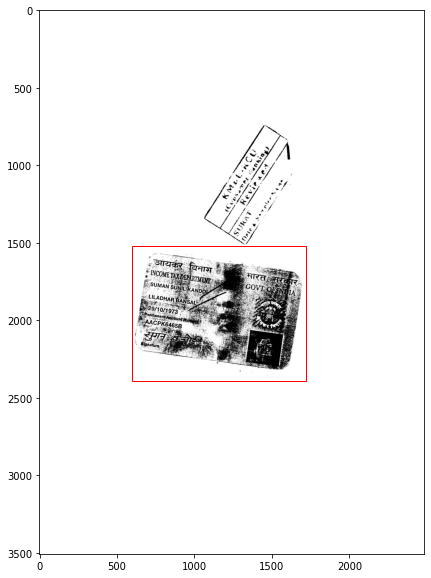

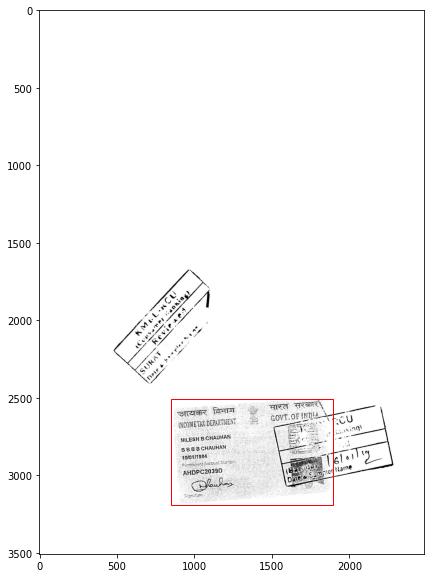

In [ ]:
sample = next(iter(dataloader))
display_training_data(sample)

### Data format testing

In [ ]:
for i, sample in enumerate(dataloader):
    images, targets = sample
    output = model(images, targets)
    print(output)
    break

/usr/local/lib/python3.6/dist-packages/torchvision/ops/boxes.py:101: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  keep = keep.nonzero().squeeze(1)


{'loss_classifier': tensor(0.6938, grad_fn=<NllLossBackward>), 'loss_box_reg': tensor(0.0549, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.6934, grad_fn=<BinaryCrossEntropyWithLogitsBackward>), 'loss_rpn_box_reg': tensor(0.0032, grad_fn=<DivBackward0>)}


### Training the model

In [ ]:
def transfer_to_device(images, targets, device):
    images = [image.to(device) for image in images]
    targets = [{k:v.to(device) for k,v in target.items()} for target in targets]

    return images, targets

In [ ]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train()
    header = 'Epoch: [{}]'.format(epoch)
    print(header)
    
    loss_hist = []
    for images, targets in tqdm(data_loader):
        images, targets = transfer_to_device(images, targets, device)
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        
        #print(header, losses, loss_dict)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        loss_hist.append(losses)
        
        del images, targets, loss_dict, losses

    return loss_hist

In [ ]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and document
num_classes = 2
# use our dataset and defined transformations
dataset = DocumentDataset(image_folder_path, target_file_path, composed_transforms)

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset_train = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset, indices[-50:])

# define training and validation data loaders
data_loader_train = torch.utils.data.DataLoader(dataset_train, batch_size=4, shuffle=True, collate_fn = my_collate)
data_loader_test = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False, collate_fn = my_collate)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                step_size=3,
                                                gamma=0.1)

In [ ]:
# let's train it for 10 epochs
num_epochs = 5

loss_per_epoch = []

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    loss_hist = train_one_epoch(model, optimizer, data_loader_train, device, epoch, print_freq=10)
    loss_per_epoch.extend(loss_hist)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

print("That's it!")

Epoch: [0]



Epoch: [1]



Epoch: [2]



Epoch: [3]



Epoch: [4]



That's it!


### Testing results

In [ ]:
def display_output_data(images, outputs):
    print(outputs)
    for image, output in zip(images, outputs):
        fig, ax = plt.subplots(1,1, figsize=(10,10))
        ax.imshow(image.cpu().numpy().transpose(1,2,0))
        for i, box in enumerate(output["boxes"]):
            if i>=2:
                break
            xmin, ymin, xmax, ymax = box
            rect = patches.Rectangle((xmin,ymin),xmax-xmin,ymax-ymin,linewidth=1,edgecolor='r',facecolor='none')
            ax.add_patch(rect)
        plt.show()

[{'boxes': tensor([[ 478.8015,  231.5201, 1563.0109, 1059.4957],
        [  89.1936,  468.8640, 1432.3091, 3118.7366],
        [ 167.0885,  172.6436, 1506.6840, 2035.7773],
        [ 176.1283, 1283.5887, 1198.8756, 2290.9915],
        [ 117.4855, 2312.2825, 1225.6858, 3148.9043]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9999, 0.9960, 0.9141, 0.0715, 0.0645], device='cuda:0',
       grad_fn=<IndexBackward>)}]


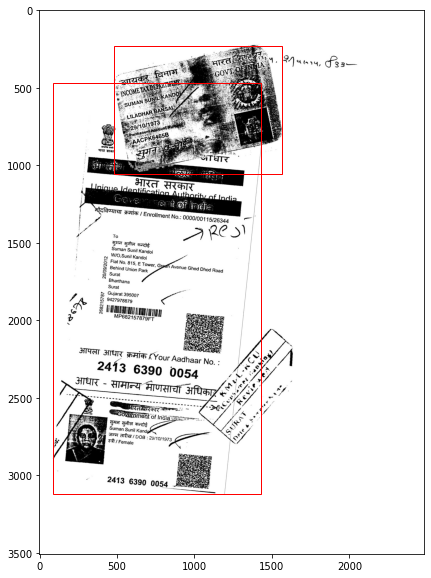

[{'boxes': tensor([[ 818.1917,  429.4336, 1864.3666, 1229.2853],
        [  81.4107,  864.9988, 1293.1151, 3209.2976],
        [ 438.7435,  351.0744, 1973.8153, 1585.3392],
        [  96.1521, 2337.7202, 1158.1606, 3298.0593],
        [ 156.1326, 1216.1288, 1178.5599, 2474.7778],
        [ 690.5273,  579.4466, 1698.0952, 1479.7405]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9997, 0.9964, 0.2683, 0.1384, 0.1239, 0.0648], device='cuda:0',
       grad_fn=<IndexBackward>)}]


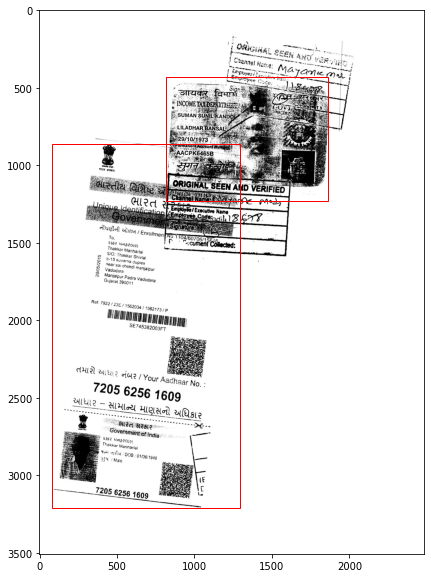

[{'boxes': tensor([[ 364.1761, 2501.3647, 1335.0038, 3249.5171]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0', grad_fn=<IndexBackward>)}]


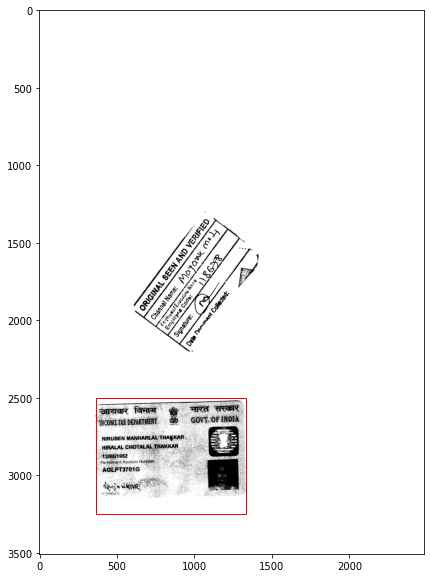

[{'boxes': tensor([[1009.7972,  136.0532, 2147.7300,  983.0893]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1], device='cuda:0'), 'scores': tensor([0.9999], device='cuda:0', grad_fn=<IndexBackward>)}]


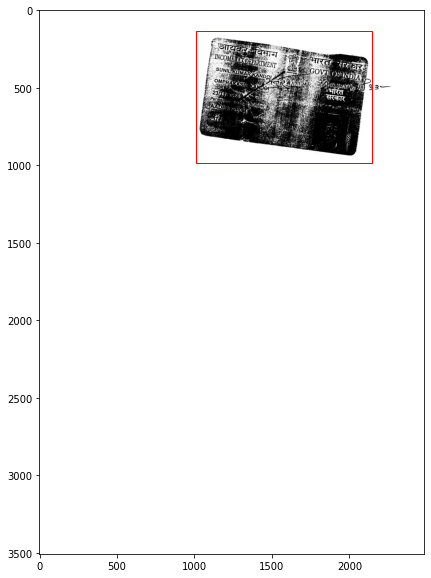

[{'boxes': tensor([[1303.4286, 1875.3911, 2402.4258, 2679.4619],
        [ 880.7987, 1166.6370, 1842.5892, 1964.4827],
        [1120.2734, 1008.1144, 1767.6239, 2580.6204],
        [1114.5009, 1240.8519, 1755.0741, 1700.8820],
        [1008.2795, 1280.8059, 2242.5115, 2776.8381]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1, 1, 1], device='cuda:0'), 'scores': tensor([0.9998, 0.9998, 0.4290, 0.0879, 0.0773], device='cuda:0',
       grad_fn=<IndexBackward>)}]


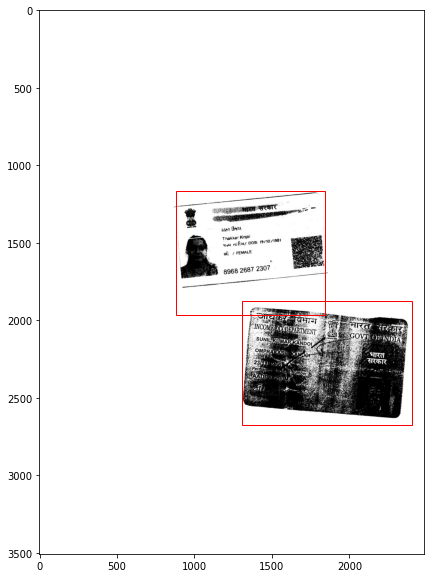

[{'boxes': tensor([[1100.8816,  791.5870, 2211.2817, 3088.6404],
        [1186.3224, 1409.9569, 2060.2278, 2305.8113],
        [1240.4681,  932.2089, 1971.8400, 2643.7751]], device='cuda:0',
       grad_fn=<StackBackward>), 'labels': tensor([1, 1, 1], device='cuda:0'), 'scores': tensor([0.9985, 0.4766, 0.1085], device='cuda:0', grad_fn=<IndexBackward>)}]


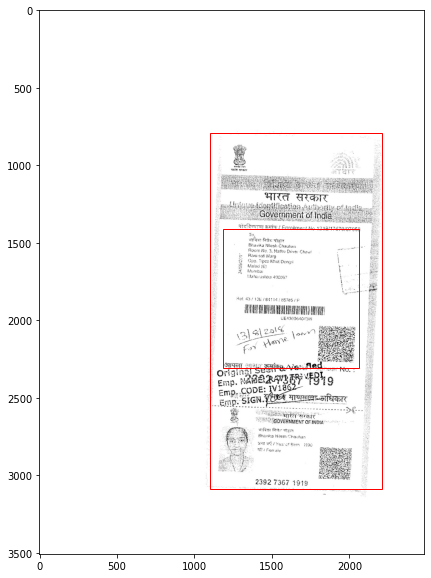

In [ ]:
model.eval()

for i, sample in enumerate(data_loader_test):
    images, targets = sample
    images, targets = transfer_to_device(images, targets, device)
    output = model(images)
    display_output_data(images, output)

    if i==5:
        break

In [ ]:
#Saving the model

torch.save(model.state_dict(), "Faster RCNN Finetuned 1000")